In [10]:
pip install kaggle



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# Set Kaggle credentials manually (provided by you)
os.environ['KAGGLE_USERNAME'] = 'jun4id'
os.environ['KAGGLE_KEY'] = 'fdcb6857a422e101550edfa6100b27eb'

# Authenticate with the Kaggle API
api = KaggleApi()
api.authenticate()
print("✅ Kaggle API authentication successful!")

# Define dataset details
dataset_name = "rajat95gupta/hazing-images-dataset-cvpr-2019"
download_dir = "./hazing_dataset"  # Directory to download and extract the dataset
os.makedirs(download_dir, exist_ok=True)

# Download and extract the dataset
print("⬇️ Downloading and extracting the dataset...")
api.dataset_download_files(dataset_name, path=download_dir, unzip=True)
print(f"✅ Dataset downloaded and extracted to '{download_dir}'.")

# List all files in the downloaded dataset
print("\n📂 Listing dataset files:")
for root, _, files in os.walk(download_dir):
    for file in files:
        print(os.path.join(root, file))


✅ Kaggle API authentication successful!
⬇️ Downloading and extracting the dataset...
Dataset URL: https://www.kaggle.com/datasets/rajat95gupta/hazing-images-dataset-cvpr-2019
✅ Dataset downloaded and extracted to './hazing_dataset'.

📂 Listing dataset files:
./hazing_dataset/GT/17_GT.png
./hazing_dataset/GT/02_GT.png
./hazing_dataset/GT/39_GT.png
./hazing_dataset/GT/32_GT.png
./hazing_dataset/GT/44_GT.png
./hazing_dataset/GT/14_GT.png
./hazing_dataset/GT/40_GT.png
./hazing_dataset/GT/54_GT.png
./hazing_dataset/GT/09_GT.png
./hazing_dataset/GT/13_GT.png
./hazing_dataset/GT/37_GT.png
./hazing_dataset/GT/12_GT.png
./hazing_dataset/GT/05_GT.png
./hazing_dataset/GT/34_GT.png
./hazing_dataset/GT/53_GT.png
./hazing_dataset/GT/28_GT.png
./hazing_dataset/GT/18_GT.png
./hazing_dataset/GT/51_GT.png
./hazing_dataset/GT/49_GT.png
./hazing_dataset/GT/11_GT.png
./hazing_dataset/GT/38_GT.png
./hazing_dataset/GT/07_GT.png
./hazing_dataset/GT/33_GT.png
./hazing_dataset/GT/30_GT.png
./hazing_dataset/GT/3

In [14]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class HazyDataset(Dataset):
    def __init__(self, hazy_files, gt_files, transform=None):
        self.hazy_files = hazy_files
        self.gt_files = gt_files
        self.transform = transform

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_img_path = self.hazy_files[idx]
        gt_img_path = self.gt_files[idx]

        hazy_image = Image.open(hazy_img_path).convert('RGB')
        gt_image = Image.open(gt_img_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            gt_image = self.transform(gt_image)

        return hazy_image, gt_image


In [15]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class HazyDataset(Dataset):
    def __init__(self, hazy_files, gt_files, transform=None):
        self.hazy_files = hazy_files
        self.gt_files = gt_files
        self.transform = transform

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_img_path = self.hazy_files[idx]
        gt_img_path = self.gt_files[idx]

        hazy_image = Image.open(hazy_img_path).convert('RGB')
        gt_image = Image.open(gt_img_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            gt_image = self.transform(gt_image)

        return hazy_image, gt_image
from torch.utils.data import DataLoader


import os

hazy_dir = "/teamspace/studios/this_studio/hazing_dataset/hazy"
hazy_files = sorted([os.path.join(hazy_dir, f) for f in os.listdir(hazy_dir)])


gt_dir = "/teamspace/studios/this_studio/hazing_dataset/GT"
gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir)])




# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = HazyDataset(hazy_files, gt_files, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Initialize models
netG = Generator()
netD = Discriminator()

# Loss functions
criterion_GAN = nn.BCELoss()
criterion_content = nn.L1Loss()
# Verify the model parameters
print("Generator parameters:", list(netG.parameters()))
print("Discriminator parameters:", list(netD.parameters()))

# Optimizers
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Check if optimizers are correctly receiving parameters
print("OptimizerG parameters:", optimizerG.param_groups[0]['params'])
print("OptimizerD parameters:", optimizerD.param_groups[0]['params'])


Generator parameters: [Parameter containing:
tensor([[[[-0.1442,  0.0743, -0.1283, -0.1443],
          [-0.0723, -0.1286,  0.0864, -0.1344],
          [-0.0017,  0.1427,  0.0057,  0.1007],
          [-0.0764,  0.0246, -0.0679,  0.1228]],

         [[-0.0635, -0.0823, -0.0136,  0.0410],
          [-0.0929, -0.0817,  0.0786, -0.0650],
          [-0.0352,  0.0814,  0.0035, -0.1248],
          [-0.0885, -0.0924, -0.0294,  0.1095]],

         [[-0.0616, -0.0533, -0.0179,  0.0793],
          [-0.1239, -0.1031, -0.0101, -0.0573],
          [ 0.1300,  0.0509,  0.0266, -0.1291],
          [ 0.0504,  0.0182,  0.0512, -0.0349]]],


        [[[-0.1366,  0.0345, -0.0662,  0.1119],
          [-0.0496, -0.0381,  0.0418, -0.1016],
          [-0.0863, -0.0830,  0.0973,  0.1026],
          [-0.0884, -0.0709, -0.1427,  0.0192]],

         [[ 0.0743, -0.0415,  0.0366,  0.0018],
          [-0.1399,  0.1008, -0.1394,  0.1042],
          [-0.1197, -0.1286, -0.0602,  0.0646],
          [ 0.0006, -0.0633,  0.0

In [19]:
num_epochs = 2000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to the appropriate device
netG.to(device)  # Move generator to device
netD.to(device)  # Move discriminator to device

for epoch in range(num_epochs):
    for i, (hazy_image, gt_image) in enumerate(dataloader):
        hazy_image, gt_image = hazy_image.to(device), gt_image.to(device)

        # Train Discriminator
        optimizerD.zero_grad()
        output_real = netD(gt_image).view(-1)
        label_real = torch.full(output_real.size(), 1, dtype=torch.float, device=device)
        loss_D_real = criterion_GAN(output_real, label_real)

        fake_image = netG(hazy_image)
        output_fake = netD(fake_image.detach()).view(-1)
        label_fake = torch.full(output_fake.size(), 0, dtype=torch.float, device=device)
        loss_D_fake = criterion_GAN(output_fake, label_fake)

        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizerD.step()

        # Train Generator
        optimizerG.zero_grad()
        output_fake = netD(fake_image).view(-1)
        loss_G_GAN = criterion_GAN(output_fake, label_real)  # Use real labels for fake images for generator loss
        loss_G_content = criterion_content(fake_image, gt_image)
        loss_G = loss_G_GAN + loss_G_content * 100
        loss_G.backward()
        optimizerG.step()

        if i % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], '
                  f'Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

print("Training complete")

Epoch [0/2000], Step [0/4], Loss D: 0.7046, Loss G: 69.9339


Epoch [1/2000], Step [0/4], Loss D: 0.6132, Loss G: 40.4542
Epoch [2/2000], Step [0/4], Loss D: 0.5681, Loss G: 38.3470
Epoch [3/2000], Step [0/4], Loss D: 0.4326, Loss G: 41.5436
Epoch [4/2000], Step [0/4], Loss D: 0.3276, Loss G: 40.2814
Epoch [5/2000], Step [0/4], Loss D: 0.3303, Loss G: 41.3455
Epoch [6/2000], Step [0/4], Loss D: 0.2841, Loss G: 37.9379
Epoch [7/2000], Step [0/4], Loss D: 0.1972, Loss G: 37.7080
Epoch [8/2000], Step [0/4], Loss D: 0.3742, Loss G: 36.8770
Epoch [9/2000], Step [0/4], Loss D: 0.2188, Loss G: 37.1769
Epoch [10/2000], Step [0/4], Loss D: 0.1252, Loss G: 39.8189
Epoch [11/2000], Step [0/4], Loss D: 0.0688, Loss G: 36.8620
Epoch [12/2000], Step [0/4], Loss D: 0.0631, Loss G: 39.8652
Epoch [13/2000], Step [0/4], Loss D: 0.0646, Loss G: 38.1780
Epoch [14/2000], Step [0/4], Loss D: 0.1411, Loss G: 35.8088
Epoch [15/2000], Step [0/4], Loss D: 0.5449, Loss G: 36.5123
Epoch [16/2000], Step [0/4], Loss D: 0.1205, Loss G: 38.7984
Epoch [17/2000], Step [0/4], Loss

In [20]:
import torch

# Assuming model is your PyTorch model
torch.save(netG.state_dict(), 'netG.pth')
torch.save(netD.state_dict(), 'netD.pth')


In [28]:
# Load the state dictionaries
netG.load_state_dict(torch.load('/teamspace/studios/this_studio/netG.pth'))
netD.load_state_dict(torch.load('/teamspace/studios/this_studio/netD.pth'))

<All keys matched successfully>

In [31]:
print("values")
netG.eval()
netD.eval()

values


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [32]:
pip install scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 176.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Average PSNR: 31.43
Average SSIM: 0.9048


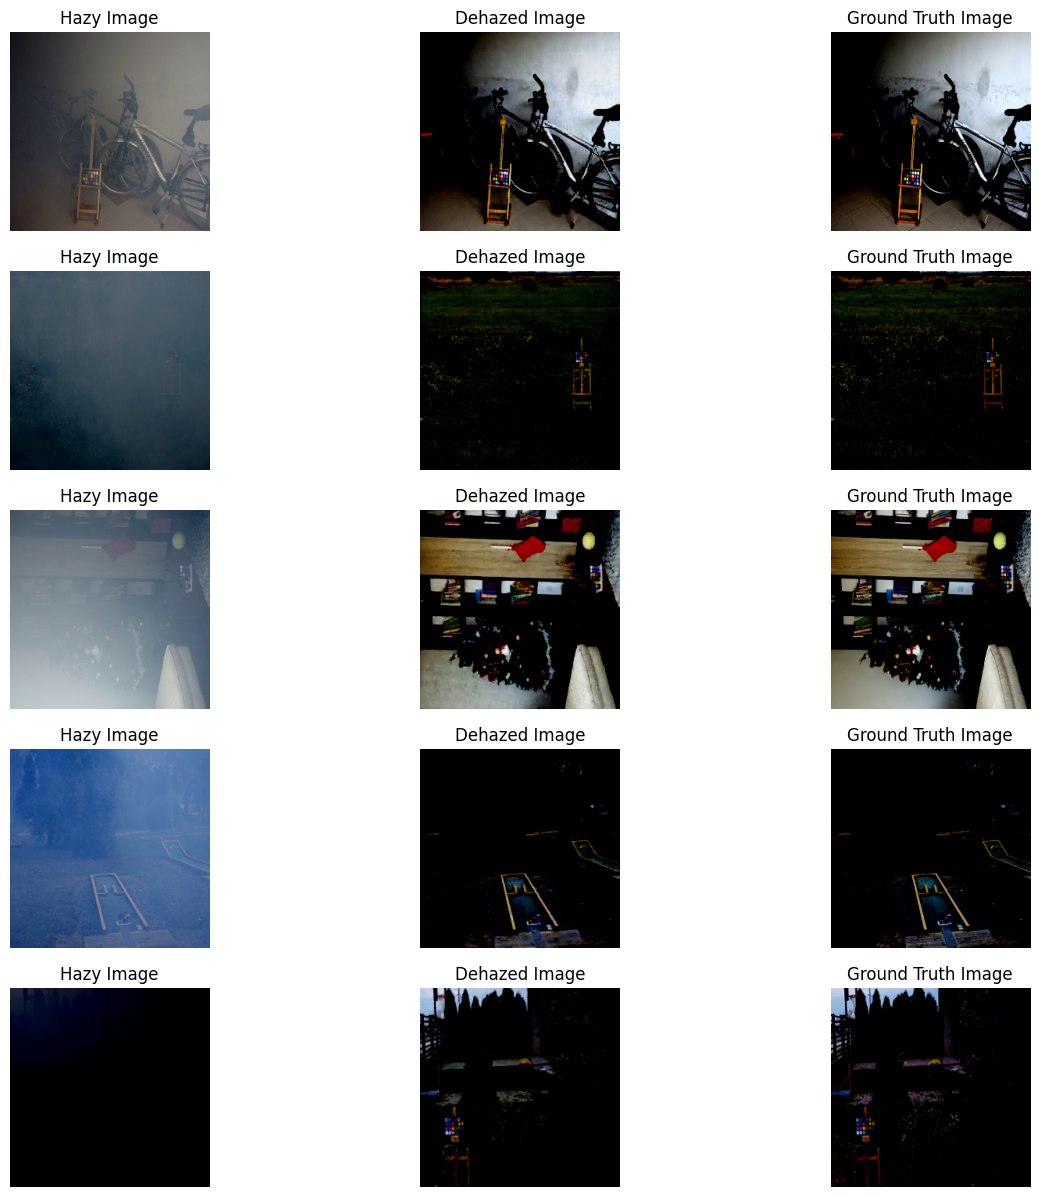

In [36]:
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Function to denormalize and convert tensor to image
def tensor_to_image(tensor):
    image = tensor.cpu().detach().numpy().transpose(1, 2, 0)  # Change dimensions to HWC
    image = np.clip(image, 0, 1)  # Ensure values are within [0, 1]
    return image

# Arrays to store images and metrics
hazy_images_list = []
dehazed_images_list = []
gt_images_list = []
psnr_values = []
ssim_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG.to(device)  # Ensure model is on the right device

# Process all images in the dataloader
for hazy_images, gt_images in dataloader:
    hazy_images, gt_images = hazy_images.to(device), gt_images.to(device)
    
    with torch.no_grad():
        dehazed_images = netG(hazy_images)  # Dehaze images

    # Convert tensors to images and store them
    for i in range(hazy_images.size(0)):
        hazy_image = tensor_to_image(hazy_images[i])
        dehazed_image = tensor_to_image(dehazed_images[i])
        gt_image = tensor_to_image(gt_images[i])

        hazy_images_list.append(hazy_image)
        dehazed_images_list.append(dehazed_image)
        gt_images_list.append(gt_image)

        # Calculate PSNR and SSIM
        psnr_value = psnr(gt_image, dehazed_image, data_range=1.0)
        ssim_value = ssim(gt_image, dehazed_image, win_size=None, data_range=1.0, channel_axis=-1)

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

# Print average PSNR and SSIM
avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)

print(f'Average PSNR: {avg_psnr:.2f}')
print(f'Average SSIM: {avg_ssim:.4f}')

# Display a few images
num_samples = min(5, len(hazy_images_list))  # Ensure we don't exceed available images
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 15))

for i in range(num_samples):
    axs[i, 0].imshow(hazy_images_list[i])
    axs[i, 0].set_title('Hazy Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(dehazed_images_list[i])
    axs[i, 1].set_title('Dehazed Image')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(gt_images_list[i])
    axs[i, 2].set_title('Ground Truth Image')
    axs[i, 2].axis('off')

plt.show()


In [34]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
# Function to denormalize and convert tensor to image
def tensor_to_image(tensor):
    image = tensor.cpu().detach().numpy().transpose(1, 2, 0)  # Change dimensions to HWC
    image = (image + 1) / 2  # Denormalize
    image = np.clip(image, 0, 1)  # Ensure values are within [0, 1]
    return image
# Arrays to store images and metrics
hazy_images_list = []
dehazed_images_list = []
gt_images_list = []
psnr_values = []
ssim_values = []

# Process all images in the dataloader
for hazy_images, gt_images in dataloader:
    with torch.no_grad():
        dehazed_images = netG(hazy_images)

    # Convert tensors to images and store them
    for i in range(hazy_images.size(0)):
        hazy_image = tensor_to_image(hazy_images[i])
        dehazed_image = tensor_to_image(dehazed_images[i])
        gt_image = tensor_to_image(gt_images[i])

        hazy_images_list.append(hazy_image)
        dehazed_images_list.append(dehazed_image)
        gt_images_list.append(gt_image)

        # Calculate PSNR and SSIM
        psnr_value = psnr(gt_image, dehazed_image, data_range=dehazed_image.max() - dehazed_image.min())
        ssim_value=ssim(gt_image, dehazed_image, win_size=11,data_range=dehazed_image.max() - dehazed_image.min(), channel_axis=-1)

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

# Print average PSNR and SSIM
avg_psnr = sum(psnr_values) / len(psnr_values)
avg_ssim = sum(ssim_values) / len(ssim_values)

print(f'Average PSNR: {avg_psnr}')
print(f'Average SSIM: {avg_ssim}')

# Display a few images (optional)
fig, axs = plt.subplots(5, 3, figsize=(15, 15))
for i in range(5):
    axs[i, 0].imshow(hazy_images_list[i])
    axs[i, 0].set_title('Hazy Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(dehazed_images_list[i])
    axs[i, 1].set_title('Dehazed Image')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(gt_images_list[i])
    axs[i, 2].set_title('Ground Truth Image')
    axs[i, 2].axis('off')

plt.show()


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [27]:
import pandas as pd
Error=pd.DataFrame({'psnr_values':psnr_values,'ssim_values':ssim_values})

NameError: name 'psnr_values' is not defined

In [11]:
Error

,psnr_values,ssim_values
0,21.302068,0.370698
1,21.849402,0.515379
2,20.224774,0.702512
3,17.543377,0.324685
4,21.968816,0.713379
5,19.829923,0.508786
6,18.664940,0.289759
7,20.586318,0.602003
8,18.369295,0.349742
9,19.532594,0.582116


In [12]:
Error.describe()

,psnr_values,ssim_values
count,55.000000,55.000000
mean,20.251685,0.505706
std,1.440896,0.126767
min,15.418039,0.273846
25%,19.473996,0.389966
50%,20.382201,0.508786
75%,21.455259,0.615156
max,23.109204,0.725913


In [13]:
Error.to_csv('/kaggle/working/evaluation_results.csv', index=False)

NameError: name 'loss_D_list' is not defined

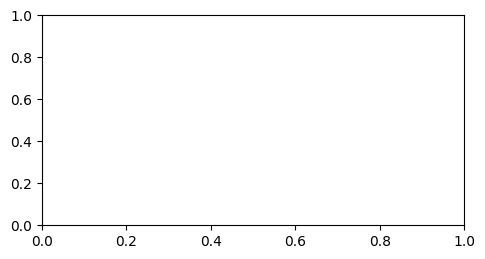

In [35]:
# Plot Loss Graphs
plt.figure(figsize=(12, 6))

# Plot Discriminator Loss
plt.subplot(2, 2, 1)
plt.plot(loss_D_list, label="Discriminator Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator Loss")
plt.legend()

# Plot Generator Loss
plt.subplot(2, 2, 2)
plt.plot(loss_G_list, label="Generator Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator Loss")
plt.legend()

# Plot GAN Loss
plt.subplot(2, 2, 3)
plt.plot(loss_GAN_list, label="GAN Loss", color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Loss")
plt.legend()

# Plot Content Loss
plt.subplot(2, 2, 4)
plt.plot(loss_content_list, label="Content Loss", color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Content Loss")
plt.legend()

plt.tight_layout()
plt.show()
# Plot Loss Graphs
plt.figure(figsize=(12, 6))

# Plot Discriminator Loss
plt.subplot(2, 2, 1)
plt.plot(loss_D_list, label="Discriminator Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator Loss")
plt.legend()

# Plot Generator Loss
plt.subplot(2, 2, 2)
plt.plot(loss_G_list, label="Generator Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator Loss")
plt.legend()

# Plot GAN Loss
plt.subplot(2, 2, 3)
plt.plot(loss_GAN_list, label="GAN Loss", color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Loss")
plt.legend()

# Plot Content Loss
plt.subplot(2, 2, 4)
plt.plot(loss_content_list, label="Content Loss", color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Content Loss")
plt.legend()

plt.tight_layout()
plt.show()
